['Relax' 'Squeeze' 'Thumb']


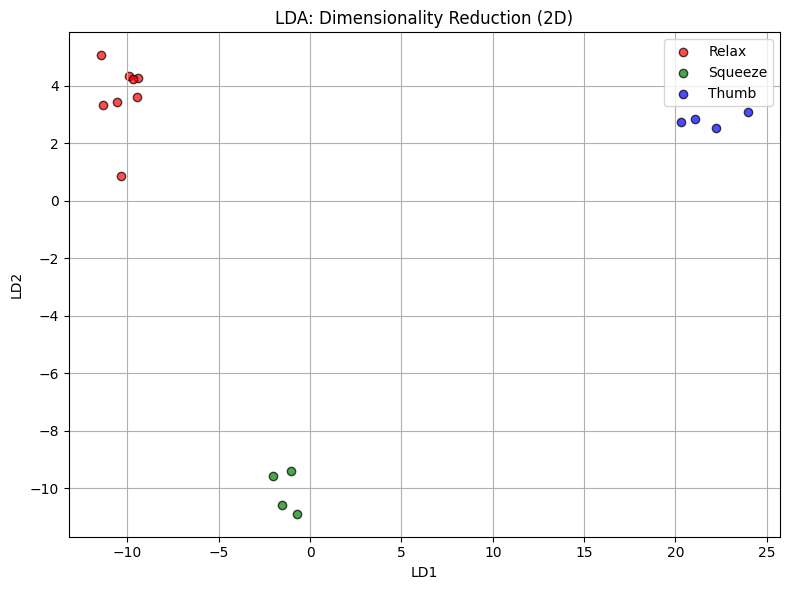

In [ ]:
import mne
from pathlib import Path
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
import numpy as np
import matplotlib.pyplot as plt
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Disable MNE logging output
mne.set_log_level('ERROR')

class Study:
    def __init__(self, csv_file, event_file, event_labels_file, sfreq=200):
        self.csv_file = csv_file
        self.event_file = event_file
        # self.event_dict = event_dict
        self.dataset_x = list()
        self.dataset_y = list()
        self.sfreq = sfreq
        self.raw = None
        self.filtered = None
        self.epochs_filtered = None
        self.events = None
        self.lda = None
        self.event_labels_file = event_labels_file

    
    def get_lda(self, n_components=2, colors=['red', 'green', 'blue', 'purple']):
        # Apply LDA to reduce to 2D
        lda = LinearDiscriminantAnalysis(n_components=n_components)
        X_lda = lda.fit_transform(self.dataset_x, self.dataset_y)

        # Create index array based on length of labels
        indices = np.arange(len(self.event_labels))

        # Plot the reduced data
        plt.figure(figsize=(8, 6))
        for color, i, label in zip(colors, indices, self.event_labels):
            plt.scatter(X_lda[self.dataset_y == i, 0], X_lda[self.dataset_y == i, 1], alpha=0.7, color=color, label=label, edgecolor='k')

        plt.title('LDA: Dimensionality Reduction (2D)')
        plt.xlabel('LD1')
        plt.ylabel('LD2')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def filter_data(self, raw, l_freq=1.0, h_freq=95.0):
        filtered = raw.copy().filter(l_freq=l_freq, h_freq=h_freq)
        self.filtered = filtered.notch_filter(freqs=60)
        return filtered

    def load_events(self, file_path):
        events = np.loadtxt(file_path, delimiter=',', dtype=int)
        return events
    
    def raw_to_epochs(self,raw, event_file, event_dict, tmin=-0.1, tmax=5.0, baseline=None, reject=None):
        events = np.array(self.load_events(event_file))  
        epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=tmin, tmax=tmax, preload=True, baseline=baseline, reject=reject)
        # psd = epochs.compute_psd()
        return epochs, events

    def csv_to_dataframe(self, file):
        eeg_channels_names = [str(i) for i in range(15)]
        df = pd.read_csv(file, usecols = eeg_channels_names).transpose()
        return df

    def df_to_raw( self, df, sfreq=200, ch_types='emg'):
        # eeg_channels_names = BoardShim.get_eeg_names(self.board_id)
        eeg_channels_names = [str(i) for i in range(df.shape[0])]
        ch_types = ['eeg'] * len(eeg_channels_names)

        # Create MNE info object
        info = mne.create_info(ch_names = eeg_channels_names, sfreq = sfreq, ch_types=ch_types)

        # Create MNE raw object
        raw = mne.io.RawArray(df, info)
        raw.load_data()
        # raw.plot(clipping=None, scalings=dict(eeg='1e3', emg='1e5'))

        return raw

    def csv_to_raw(self, file, start_channel=0, end_channel=15):
        df = self.csv_to_dataframe(file)
        df = df.iloc[start_channel:end_channel, :]
        raw = self.df_to_raw(df)
        return raw

    def get_band_powers(self, epoch):
        [avgs, stddevs] = DataFilter.get_custom_band_powers(epoch, [(1,10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 90)], [0], self.sfreq, False)
        return avgs

    def get_band_power_by_epoch(self, epochs, epoch_index):
        selected_epoch = epochs[epoch_index, :, :].reshape(1, -1)
        avgs = self.get_band_powers(selected_epoch)
        return avgs

    def add_data_and_labels(self, epochs, event_id, label):
        epochs_data = epochs[event_id].get_data()
        for i in range(epochs_data.shape[0]):
            avgs = self.get_band_power_by_epoch(epochs_data, i)
            self.dataset_x.append(avgs)
            self.dataset_y.append(label)
    
    def run_study(self, csv_file, event_file, plot_epochs=False):
        self.raw = self.csv_to_raw(csv_file, 1, 2)
        self.filtered = self.filter_data(self.raw)
        self.event_labels =  np.loadtxt(self.event_labels_file, delimiter=',', dtype=str)
        print(self.event_labels)
        self.event_dict = {str(label): i for i, label in enumerate(self.event_labels)}

        epochs_filtered, events = self.raw_to_epochs(self.filtered, event_file, self.event_dict)
        self.epochs_filtered = epochs_filtered
        if plot_epochs:
            print("Plotting epochs")
            self.epochs_filtered.plot(scalings=dict(eeg='1e3', emg='1e5'), events=events)

        self.events = events

        for event_name, event_id in self.event_dict.items():
            self.add_data_and_labels(self.epochs_filtered, event_name, event_id)

        self.dataset_x = np.array(self.dataset_x)
        self.dataset_y = np.array(self.dataset_y)

    def run(self, plot_epochs=False):
        self.run_study(self.csv_file, self.event_file, plot_epochs)

study = Study("data/study2_data.csv", "events/study2.txt", "events/study1_event_labels.txt")
study.run()
study.get_lda()




